Recommended Fertilizer Type: 10-26-26
Recommended Fertilizer Quantity (kg/ha): 51.10
Recommended Crop: Tobacco
Carbon Footprint: 8.84 kg CO₂ equivalent
Cost per kg: Rs 24
Total Cost: Rs 1226.40
Overall accuracy: 99.01
Soil Type Labels:
0: Black
1: Clayey
2: Loamy
3: Red
4: Sandy


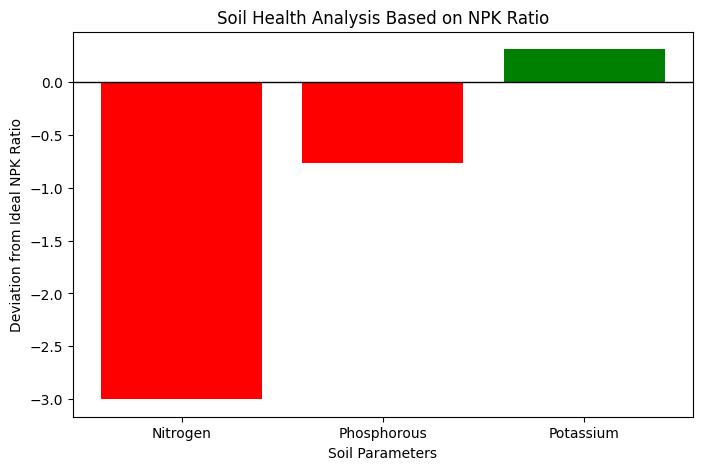

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

data = pd.read_csv('Fertilizer.csv')

fertilizer_emission_factors = {
    "Urea": {"N": 0.62},
    "DAP": {"N": 1.84},
    "SSP": {"P2O5": 0.06},
    "MOP": {"K2O": 0.25},
    "10-26-26": {"N": 1.73},
    "17-17-17": {"N": 1.72},
    "28-28":{"N":0.38},
    "20-20":{"N":0.4},
    "14-35-14":{"P2O5":0.57}
}

fertilizer_costs = {
    "Urea": 29.5,
    "DAP": 27,
    "SSP": 29,
    "MOP": 37,
    "10-26-26": 24,
    "17-17-17": 60,
    "28-28":75,
    "20-20":68,
    "14-35-14":18
}

# Fertilizer NPK content (percentage composition per kg of fertilizer)
fertilizer_npk_content = {
    "Urea": {"N": 46, "P2O5": 0, "K2O": 0},
    "DAP": {"N": 18, "P2O5": 46, "K2O": 0},
    "SSP": {"N": 0, "P2O5": 16, "K2O": 0},
    "MOP": {"N": 0, "P2O5": 0, "K2O": 60},
    "10-26-26": {"N": 10, "P2O5": 26, "K2O": 26},
    "17-17-17": {"N": 17, "P2O5": 17, "K2O": 17},
    "14-35-14": {"N": 14, "P2O5": 35, "K2O": 14},
    "28-28": {"N": 28, "P2O5": 28, "K2O": 0},
    "20-20": {"N": 20, "P2O5": 20, "K2O": 0},
    "14-35-14":{"N":14,"P2O5":35,"K2O":14}

}

# Encode categorical columns
label_encoder_fertilizer = LabelEncoder()
data['Fertilizer Type'] = label_encoder_fertilizer.fit_transform(data['Fertilizer Type'])
label_encoder_soil = LabelEncoder()
data['Soil Type'] = label_encoder_soil.fit_transform(data['Soil Type'])
label_encoder_crop = LabelEncoder()
data['Crop Name'] = label_encoder_crop.fit_transform(data['Crop Name'])

# Define features and targets
X = data[['Nitrogen', 'Phosphorous', 'Potassium', 'pH_Value', 'Temparature', 'Moisture', 'Soil Type']]
y_fertilizer = data['Fertilizer Type']
y_quantity = np.log1p(data['Fertilizer Quantity'])  # Log transformation
y_crop = data['Crop Name']

# Split dataset
X_train, X_test, y_fertilizer_train, y_fertilizer_test = train_test_split(X, y_fertilizer, test_size=0.2, random_state=42)
X_train_qty, X_test_qty, y_qty_train, y_qty_test = train_test_split(X, y_quantity, test_size=0.2, random_state=42)
X_train_crop, X_test_crop, y_crop_train, y_crop_test = train_test_split(X, y_crop, test_size=0.2, random_state=42)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_qty_scaled = scaler.transform(X_train_qty)
X_test_qty_scaled = scaler.transform(X_test_qty)
X_train_crop_scaled = scaler.transform(X_train_crop)
X_test_crop_scaled = scaler.transform(X_test_crop)

# Train models with improved hyperparameters
fertilizer_model = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=42, class_weight='balanced')
fertilizer_model.fit(X_train_scaled, y_fertilizer_train)

quantity_model = RandomForestRegressor(n_estimators=550, max_depth=20, random_state=42)
quantity_model.fit(X_train_qty_scaled, y_qty_train)

crop_model = RandomForestClassifier(n_estimators=550, max_depth=20, random_state=42, class_weight='balanced')
crop_model.fit(X_train_crop_scaled, y_crop_train)

# Function to recommend fertilizer, quantity, and crop
def recommend_fertilizer_quantity_and_crop(soil_data):
    soil_data_df = pd.DataFrame([soil_data], columns=['Nitrogen', 'Phosphorous', 'Potassium', 'pH_Value', 'Temparature', 'Moisture', 'Soil Type'])
    soil_data_scaled = scaler.transform(soil_data_df)

    # Fertilizer prediction
    predicted_fertilizer_type = fertilizer_model.predict(soil_data_scaled)
    fertilizer_name = label_encoder_fertilizer.inverse_transform(predicted_fertilizer_type)[0]

    # Quantity prediction (ensure positive values)
    predicted_log_quantity = quantity_model.predict(soil_data_scaled)[0]
    predicted_quantity = max(0, np.expm1(predicted_log_quantity))

    # Crop prediction
    predicted_crop = crop_model.predict(soil_data_scaled)
    crop_name = label_encoder_crop.inverse_transform(predicted_crop)[0]

    # Calculate carbon footprint using fertilizer NPK content
    npk_content = fertilizer_npk_content.get(fertilizer_name, {"N": 0, "P2O5": 0, "K2O": 0})
    emission_factor = fertilizer_emission_factors.get(fertilizer_name, {})

    nitrogen_applied = npk_content.get("N", 0) * predicted_quantity / 100
    phosphorus_applied = npk_content.get("P2O5", 0) * predicted_quantity / 100
    potassium_applied = npk_content.get("K2O", 0) * predicted_quantity / 100

    co2_emission = (
        nitrogen_applied * emission_factor.get("N", 0) +
        phosphorus_applied * emission_factor.get("P2O5", 0) +
        potassium_applied * emission_factor.get("K2O", 0)
    )

    # Calculate cost per kg and total cost
    cost_per_kg = fertilizer_costs.get(fertilizer_name, 0)
    total_cost = predicted_quantity * cost_per_kg
    return fertilizer_name, predicted_quantity, crop_name, co2_emission, cost_per_kg, total_cost

def plot_npk_ratio(npk):
    nitrogen, phosphorus, potassium=npk[:3]
    npk_actual_ratio = np.array([nitrogen, phosphorus, potassium]) / min(nitrogen, phosphorus, potassium)
    npk_ideal_ratio = np.array([4, 2, 1])
    npk_deviation = npk_actual_ratio - npk_ideal_ratio

    # Plot soil health deviation graph
    plt.figure(figsize=(8, 5))
    plt.bar(['Nitrogen', 'Phosphorous', 'Potassium'], npk_deviation, color=['green' if x >= 0 else 'red' for x in npk_deviation])
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel("Soil Parameters")
    plt.ylabel("Deviation from Ideal NPK Ratio")
    plt.title("Soil Health Analysis Based on NPK Ratio")
    plt.show()
# Evaluate model accuracy
fertilizer_accuracy = accuracy_score(y_fertilizer_test, fertilizer_model.predict(X_test_scaled)) * 100
quantity_r2_score = r2_score(np.expm1(y_qty_test), np.clip(np.expm1(quantity_model.predict(X_test_qty_scaled)), 0, None)) * 100


# Calculate overall accuracy
overall_accuracy = (fertilizer_accuracy + quantity_r2_score  ) / 2
# Example input
data_example =  [13,16,17,5.1,29,30,3]
result = recommend_fertilizer_quantity_and_crop(data_example)

# Print results
print(f"Recommended Fertilizer Type: {result[0]}")
print(f"Recommended Fertilizer Quantity (kg/ha): {result[1]:.2f}")
print(f"Recommended Crop: {result[2]}")
print(f"Carbon Footprint: {result[3]:.2f} kg CO₂ equivalent")
print(f"Cost per kg: Rs {result[4]}")
print(f"Total Cost: Rs {result[5]:.2f}")
print(f"Overall accuracy: {overall_accuracy:.2f}")
print("Soil Type Labels:")
for index, label in enumerate(label_encoder_soil.classes_):
    print(f"{index}: {label}")
# Plot NPK ratio
plot_npk_ratio(data_example)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Recommended Fertilizer Type: 17-17-17
Recommended Fertilizer Quantity (kg/ha): 35.51
Recommended Crop: Paddy
Carbon Footprint: 10.38 kg CO₂ equivalent
Cost per kg: Rs 60
Total Cost: Rs 2130.49
Overall accuracy: 94.40%


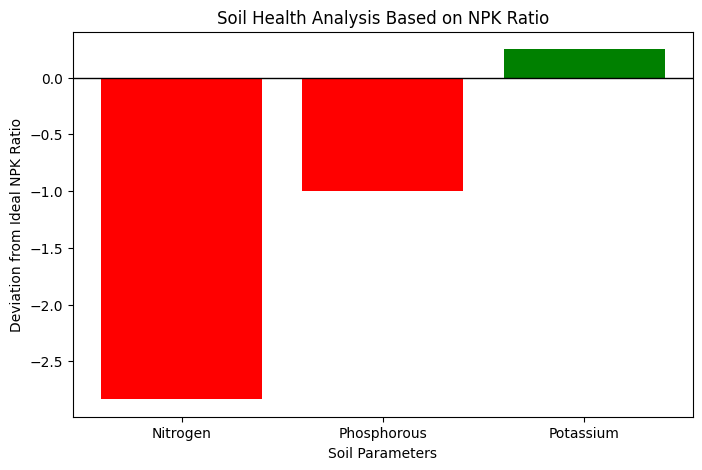

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, r2_score

data = pd.read_csv('Fertilizer.csv')

fertilizer_emission_factors = {
    "Urea": {"N": 0.62},
    "DAP": {"N": 1.84},
    "SSP": {"P2O5": 0.06},
    "MOP": {"K2O": 0.25},
    "10-26-26": {"N": 1.73},
    "17-17-17": {"N": 1.72},
    "28-28": {"N": 0.38},
    "20-20": {"N": 0.4},
    "14-35-14": {"P2O5": 0.57}
}

fertilizer_costs = {
    "Urea": 29.5,
    "DAP": 27,
    "SSP": 29,
    "MOP": 37,
    "10-26-26": 24,
    "17-17-17": 60,
    "28-28": 75,
    "20-20": 68,
    "14-35-14": 18
}
fertilizer_npk_content = {
    "Urea": {"N": 46, "P2O5": 0, "K2O": 0},
    "DAP": {"N": 18, "P2O5": 46, "K2O": 0},
    "SSP": {"N": 0, "P2O5": 16, "K2O": 0},
    "MOP": {"N": 0, "P2O5": 0, "K2O": 60},
    "10-26-26": {"N": 10, "P2O5": 26, "K2O": 26},
    "17-17-17": {"N": 17, "P2O5": 17, "K2O": 17},
    "14-35-14": {"N": 14, "P2O5": 35, "K2O": 14},
    "28-28": {"N": 28, "P2O5": 28, "K2O": 0},
    "20-20": {"N": 20, "P2O5": 20, "K2O": 0},
    "14-35-14":{"N":14,"P2O5":35,"K2O":14}

}

# Encode categorical columns
label_encoder_fertilizer = LabelEncoder()
data['Fertilizer Type'] = label_encoder_fertilizer.fit_transform(data['Fertilizer Type'])
label_encoder_soil = LabelEncoder()
data['Soil Type'] = label_encoder_soil.fit_transform(data['Soil Type'])
label_encoder_crop = LabelEncoder()
data['Crop Name'] = label_encoder_crop.fit_transform(data['Crop Name'])

# Define features and targets
X = data[['Nitrogen', 'Phosphorous', 'Potassium', 'pH_Value', 'Temparature', 'Moisture', 'Soil Type']]
y_fertilizer = data['Fertilizer Type']
y_quantity = np.log1p(data['Fertilizer Quantity'])
y_crop = data['Crop Name']

# Split dataset
X_train, X_test, y_fertilizer_train, y_fertilizer_test = train_test_split(X, y_fertilizer, test_size=0.2, random_state=42)
X_train_qty, X_test_qty, y_qty_train, y_qty_test = train_test_split(X, y_quantity, test_size=0.2, random_state=42)
X_train_crop, X_test_crop, y_crop_train, y_crop_test = train_test_split(X, y_crop, test_size=0.2, random_state=42)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM models
fertilizer_model = SVC(kernel='rbf', C=1, gamma='scale')
fertilizer_model.fit(X_train_scaled, y_fertilizer_train)

quantity_model = SVR(kernel='rbf', C=1, gamma='scale')
quantity_model.fit(X_train_scaled, y_qty_train)

crop_model = SVC(kernel='rbf', C=1, gamma='scale')
crop_model.fit(X_train_scaled, y_crop_train)

def recommend_fertilizer_quantity_and_crop(soil_data):
    soil_data_scaled = scaler.transform([soil_data])

    predicted_fertilizer_type = fertilizer_model.predict(soil_data_scaled)
    fertilizer_name = label_encoder_fertilizer.inverse_transform(predicted_fertilizer_type)[0]

    predicted_log_quantity = quantity_model.predict(soil_data_scaled)[0]
    predicted_quantity = max(0, np.expm1(predicted_log_quantity))

    predicted_crop = crop_model.predict(soil_data_scaled)
    crop_name = label_encoder_crop.inverse_transform(predicted_crop)[0]

    # Calculate carbon footprint using fertilizer NPK content
    npk_content = fertilizer_npk_content.get(fertilizer_name, {"N": 0, "P2O5": 0, "K2O": 0})
    emission_factor = fertilizer_emission_factors.get(fertilizer_name, {})

    nitrogen_applied = npk_content.get("N", 0) * predicted_quantity / 100
    phosphorus_applied = npk_content.get("P2O5", 0) * predicted_quantity / 100
    potassium_applied = npk_content.get("K2O", 0) * predicted_quantity / 100

    co2_emission = (
        nitrogen_applied * emission_factor.get("N", 0) +
        phosphorus_applied * emission_factor.get("P2O5", 0) +
        potassium_applied * emission_factor.get("K2O", 0)
    )


    cost_per_kg = fertilizer_costs.get(fertilizer_name, 0)
    total_cost = predicted_quantity * cost_per_kg

    return fertilizer_name, predicted_quantity, crop_name, co2_emission, cost_per_kg, total_cost

def plot_npk_ratio(npk):
    nitrogen, phosphorus, potassium = npk[:3]
    npk_actual_ratio = np.array([nitrogen, phosphorus, potassium]) / min(nitrogen, phosphorus, potassium)
    npk_ideal_ratio = np.array([4, 2, 1])
    npk_deviation = npk_actual_ratio - npk_ideal_ratio

    plt.figure(figsize=(8, 5))
    plt.bar(['Nitrogen', 'Phosphorous', 'Potassium'], npk_deviation, color=['green' if x >= 0 else 'red' for x in npk_deviation])
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel("Soil Parameters")
    plt.ylabel("Deviation from Ideal NPK Ratio")
    plt.title("Soil Health Analysis Based on NPK Ratio")
    plt.show()

fertilizer_accuracy = accuracy_score(y_fertilizer_test, fertilizer_model.predict(X_test_scaled)) * 100
quantity_r2_score = r2_score(np.expm1(y_qty_test), np.clip(np.expm1(quantity_model.predict(X_test_scaled)), 0, None)) * 100

overall_accuracy = (fertilizer_accuracy + quantity_r2_score) / 2

data_example = [14,12,15,7.5,32,47,2]
result = recommend_fertilizer_quantity_and_crop(data_example)

print(f"Recommended Fertilizer Type: {result[0]}")
print(f"Recommended Fertilizer Quantity (kg/ha): {result[1]:.2f}")
print(f"Recommended Crop: {result[2]}")
print(f"Carbon Footprint: {result[3]:.2f} kg CO₂ equivalent")
print(f"Cost per kg: Rs {result[4]}")
print(f"Total Cost: Rs {result[5]:.2f}")
print(f"Overall accuracy: {overall_accuracy:.2f}%")

plot_npk_ratio(data_example)

Recommended Fertilizer Type: Urea
Recommended Fertilizer Quantity (kg/ha): 36.88
Recommended Crop: Millets
Carbon Footprint (kg CO2): 10.52
Cost per kg: 29.50
Total Fertilizer Cost: 1087.90
Overall Prediction Accuracy: 92.98%


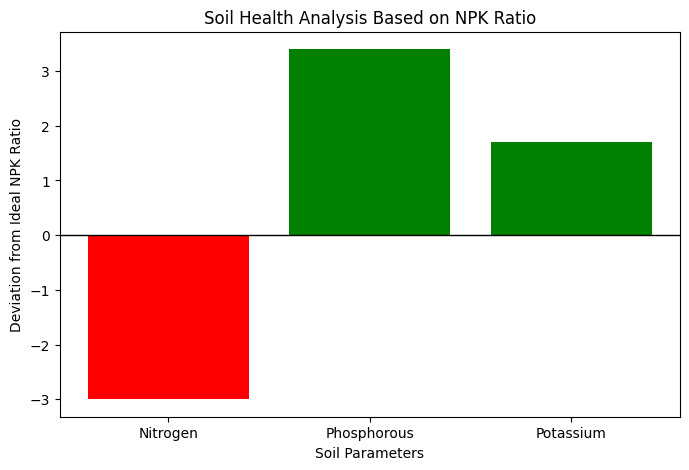

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score

# Load dataset
data = pd.read_csv('Fertilizer.csv')

# Encode categorical columns
label_encoder_fertilizer = LabelEncoder()
data['Fertilizer Type'] = label_encoder_fertilizer.fit_transform(data['Fertilizer Type'])
label_encoder_soil = LabelEncoder()
data['Soil Type'] = label_encoder_soil.fit_transform(data['Soil Type'])
label_encoder_crop = LabelEncoder()
data['Crop Name'] = label_encoder_crop.fit_transform(data['Crop Name'])

# Define features and targets
X = data[['Nitrogen', 'Phosphorous', 'Potassium', 'pH_Value', 'Temparature', 'Moisture', 'Soil Type']]
y_fertilizer = data['Fertilizer Type']
y_quantity = np.log1p(data['Fertilizer Quantity'])  # Log transformation
y_crop = data['Crop Name']

# Split dataset
X_train, X_test, y_fertilizer_train, y_fertilizer_test = train_test_split(X, y_fertilizer, test_size=0.2, random_state=42)
X_train_qty, X_test_qty, y_qty_train, y_qty_test = train_test_split(X, y_quantity, test_size=0.2, random_state=42)
X_train_crop, X_test_crop, y_crop_train, y_crop_test = train_test_split(X, y_crop, test_size=0.2, random_state=42)

# Apply separate scalers for each model
scaler_fertilizer = MinMaxScaler()
X_train_fertilizer_scaled = scaler_fertilizer.fit_transform(X_train)
X_test_fertilizer_scaled = scaler_fertilizer.transform(X_test)

scaler_quantity = MinMaxScaler()
X_train_qty_scaled = scaler_quantity.fit_transform(X_train_qty)
X_test_qty_scaled = scaler_quantity.transform(X_test_qty)

scaler_crop = MinMaxScaler()
X_train_crop_scaled = scaler_crop.fit_transform(X_train_crop)
X_test_crop_scaled = scaler_crop.transform(X_test_crop)

# Train models
fertilizer_model = GaussianNB()
fertilizer_model.fit(X_train_fertilizer_scaled, y_fertilizer_train)

crop_model = GaussianNB()
crop_model.fit(X_train_crop_scaled, y_crop_train)

quantity_model = LinearRegression()
quantity_model.fit(X_train_qty_scaled, y_qty_train)

# Fertilizer carbon footprint and cost data
fertilizer_emission_factors = {
    "Urea": {"N": 0.62},
    "DAP": {"N": 1.84},
    "SSP": {"P2O5": 0.06},
    "MOP": {"K2O": 0.25},
    "10-26-26": {"N": 1.73},
    "17-17-17": {"N": 1.72},
    "28-28": {"N": 0.38},
    "20-20": {"N": 0.4},
    "14-35-14": {"P2O5": 0.57}
}

fertilizer_costs = {
    "Urea": 29.5,
    "DAP": 27,
    "SSP": 29,
    "MOP": 37,
    "10-26-26": 24,
    "17-17-17": 60,
    "28-28": 75,
    "20-20": 68,
    "14-35-14": 18
}

fertilizer_npk_content = {
    "Urea": {"N": 46, "P2O5": 0, "K2O": 0},
    "DAP": {"N": 18, "P2O5": 46, "K2O": 0},
    "SSP": {"N": 0, "P2O5": 16, "K2O": 0},
    "MOP": {"N": 0, "P2O5": 0, "K2O": 60},
    "10-26-26": {"N": 10, "P2O5": 26, "K2O": 26},
    "17-17-17": {"N": 17, "P2O5": 17, "K2O": 17},
    "14-35-14": {"N": 14, "P2O5": 35, "K2O": 14},
    "28-28": {"N": 28, "P2O5": 28, "K2O": 0},
    "20-20": {"N": 20, "P2O5": 20, "K2O": 0}
}

# Prediction function
def recommend_fertilizer_quantity_and_crop(soil_data):
    soil_data_df = pd.DataFrame([soil_data], columns=['Nitrogen', 'Phosphorous', 'Potassium', 'pH_Value', 'Temparature', 'Moisture', 'Soil Type'])
    soil_data_scaled_fertilizer = scaler_fertilizer.transform(soil_data_df)
    soil_data_scaled_quantity = scaler_quantity.transform(soil_data_df)
    soil_data_scaled_crop = scaler_crop.transform(soil_data_df)

    predicted_fertilizer_type = fertilizer_model.predict(soil_data_scaled_fertilizer)
    fertilizer_name = label_encoder_fertilizer.inverse_transform(predicted_fertilizer_type)[0]

    predicted_log_quantity = quantity_model.predict(soil_data_scaled_quantity)[0]
    predicted_quantity = max(0, np.expm1(predicted_log_quantity))

    predicted_crop_type = crop_model.predict(soil_data_scaled_crop)
    crop_name = label_encoder_crop.inverse_transform(predicted_crop_type)[0]

    npk_content = fertilizer_npk_content.get(fertilizer_name, {"N": 0, "P2O5": 0, "K2O": 0})
    emission_factor = fertilizer_emission_factors.get(fertilizer_name, {})

    nitrogen_applied = npk_content.get("N", 0) * predicted_quantity / 100
    phosphorus_applied = npk_content.get("P2O5", 0) * predicted_quantity / 100
    potassium_applied = npk_content.get("K2O", 0) * predicted_quantity / 100

    co2_emission = (
        nitrogen_applied * emission_factor.get("N", 0) +
        phosphorus_applied * emission_factor.get("P2O5", 0) +
        potassium_applied * emission_factor.get("K2O", 0)
    )

    cost_per_kg = fertilizer_costs.get(fertilizer_name, 0)
    total_cost = predicted_quantity * cost_per_kg

    return fertilizer_name, predicted_quantity, crop_name, co2_emission, cost_per_kg, total_cost

# Evaluation corrected
fertilizer_accuracy = accuracy_score(y_fertilizer_test, fertilizer_model.predict(X_test_fertilizer_scaled)) * 100
quantity_r2_score = r2_score(np.expm1(y_qty_test), np.clip(np.expm1(quantity_model.predict(X_test_qty_scaled)), 0, None)) * 100
overall_accuracy = (fertilizer_accuracy + quantity_r2_score) / 2

# Example Test
data_example = [20, 108, 54, 7.5, 31, 48, 4]
fertilizer_name, predicted_quantity, crop_name, carbon_footprint, cost_per_kg_yield, total_cost = recommend_fertilizer_quantity_and_crop(data_example)

print(f"Recommended Fertilizer Type: {fertilizer_name}")
print(f"Recommended Fertilizer Quantity (kg/ha): {predicted_quantity:.2f}")
print(f"Recommended Crop: {crop_name}")
print(f"Carbon Footprint (kg CO2): {carbon_footprint:.2f}")
print(f"Cost per kg: {cost_per_kg_yield:.2f}")
print(f"Total Fertilizer Cost: {total_cost:.2f}")
print(f"Overall Prediction Accuracy: {overall_accuracy:.2f}%")

# Plot NPK Ratio
def plot_npk_ratio(npk):
    nitrogen, phosphorus, potassium = npk[:3]
    npk_actual_ratio = np.array([nitrogen, phosphorus, potassium]) / min(nitrogen, phosphorus, potassium)
    npk_ideal_ratio = np.array([4, 2, 1])
    npk_deviation = npk_actual_ratio - npk_ideal_ratio

    plt.figure(figsize=(8, 5))
    plt.bar(['Nitrogen', 'Phosphorous', 'Potassium'], npk_deviation,
            color=['green' if x >= 0 else 'red' for x in npk_deviation])
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel("Soil Parameters")
    plt.ylabel("Deviation from Ideal NPK Ratio")
    plt.title("Soil Health Analysis Based on NPK Ratio")
    plt.show()

# Plot the test case
plot_npk_ratio(data_example)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
data = pd.read_csv('Fertilizer.csv')

# Encode categorical columns
label_encoder_fertilizer = LabelEncoder()
data['Fertilizer Type'] = label_encoder_fertilizer.fit_transform(data['Fertilizer Type'])
label_encoder_soil = LabelEncoder()
data['Soil Type'] = label_encoder_soil.fit_transform(data['Soil Type'])
label_encoder_crop = LabelEncoder()
data['Crop Name'] = label_encoder_crop.fit_transform(data['Crop Name'])

# Define features and target
X = data[['Nitrogen', 'Phosphorous', 'Potassium', 'pH_Value', 'Temparature', 'Moisture', 'Soil Type']]
y_fertilizer = data['Fertilizer Type']

# Split dataset (same split for all models)
X_train, X_test, y_train, y_test = train_test_split(X, y_fertilizer, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM Model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Train Naïve Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)

# Calculate confusion matrices
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_nb = confusion_matrix(y_test, y_pred_nb)


# Print classification reports
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      0.96      0.98        23
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00        52

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      1.00       200

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        41
           5